In [32]:
#----------------------------------------------------------------
# Load libraries
#----------------------------------------------------------------
import numpy as np
import math

from gwpy.timeseries import TimeSeries

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

import os

%matplotlib inline

In [33]:
# Set parameters
#----------------------------------------------------------------
fn = 'H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5' # data file
tevent = 1126259462.422 # Mon Sep 14 09:50:45 GMT 2015
evtname = 'GW150914' # event name

detector = 'H1' # detecotr: L1 or H1

fn2 = 'L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5' # data file
tevent = 1126259462.422 # Mon Sep 14 09:50:45 GMT 2015
evtname = 'GW150914' # event name

detector = 'H1' # detecotr: L1 or H1
detector2 = 'L1'

In [34]:
#----------------------------------------------------------------
# Load LIGO data
#----------------------------------------------------------------
strain = TimeSeries.read(fn, format='hdf5.losc')
strain2 = TimeSeries.read(fn2, format='hdf5.losc')
center = int(tevent)
strain = strain.crop(center-16, center+16)
strain2 = strain2.crop(center-16, center+16)

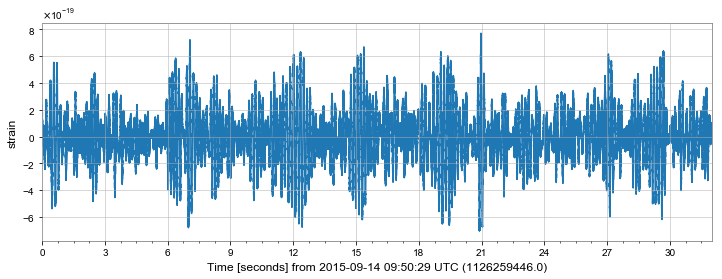

0.000244140625 s


In [136]:
# Show LIGO strain vs. time
#----------------------------------------------------------------
plt.figure()
strain.plot()
plt.ylabel('strain')
plt.show()
print(strain.dt)

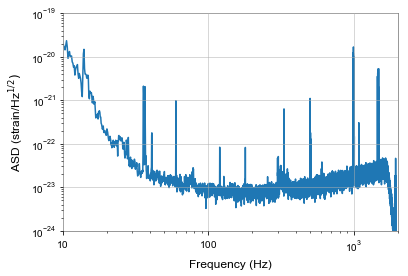

In [35]:
# Obtain the power spectrum density PSD / ASD
#----------------------------------------------------------------

asd = strain.asd(fftlength=8)
asd2 = strain2.asd(fftlength=8)

plt.clf()
asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

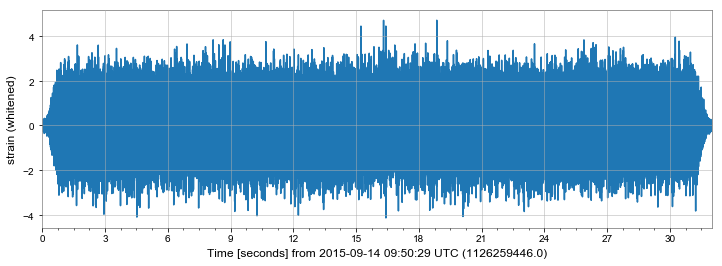

In [143]:
#----------------------------------------------------------------
# Whitening data
#----------------------------------------------------------------

white_data = strain.whiten()
white_data2 = strain2.whiten()

#asd3 = white_data.asd(fftlength=8)


plt.clf()
white_data.plot()
#asd3.plot()
plt.ylabel('strain (whitened)')
plt.show()

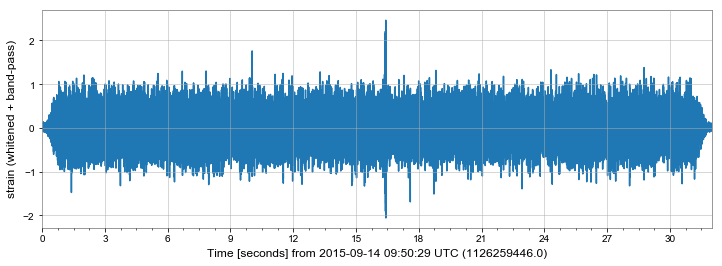

In [235]:
#----------------------------------------------------------------
# Bandpass filtering
#----------------------------------------------------------------
bandpass_low = 15
bandpass_high = 400

white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)
white_data_bp2 = white_data2.bandpass(bandpass_low, bandpass_high)

plt.clf()
white_data_bp.plot()

sample_times = white_data_bp.times.value
sample_data = white_data_bp.value
indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

short_series = TimeSeries(white_data_bp_zoom, t0 = strain.t0, dt = strain.dt, name = 'Strain')

plt.ylabel('strain (whitened + band-pass)')
asd3 = short_series.asd()
#asd3.plot()
plt.show()

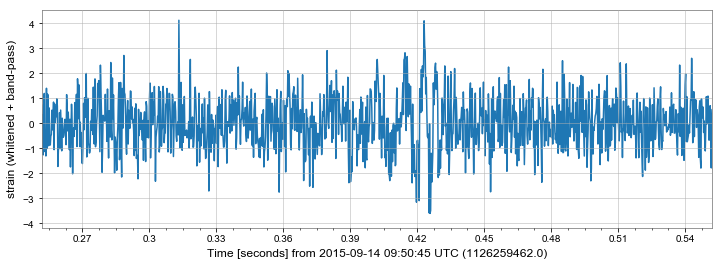

In [234]:
plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.xlim(tevent-0.17, tevent+0.13)
plt.show()

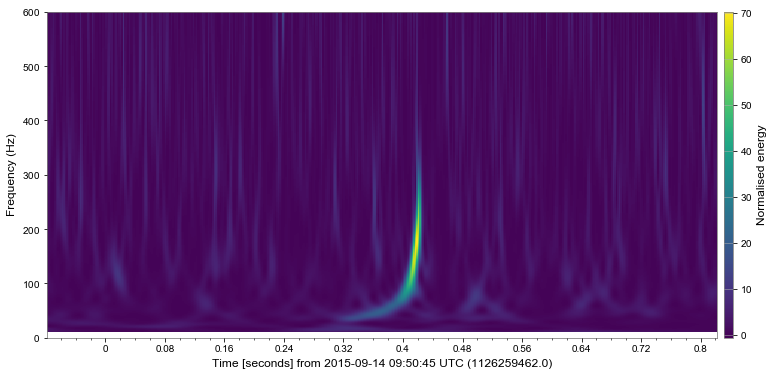

In [140]:
#----------------------------------------------------------------
# q-transform
#----------------------------------------------------------------

dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))
hq2 = strain2.q_transform(outseg=(tevent-dt, tevent+dt))

plt.clf()
fig = hq2.plot()
ax = fig.gca()
fig.colorbar(label="Normalised energy")
ax.grid(False)
plt.xlim(tevent-0.5, tevent+0.4)
plt.ylim(0, 400)
plt.ylabel('Frequency (Hz)')
plt.show()

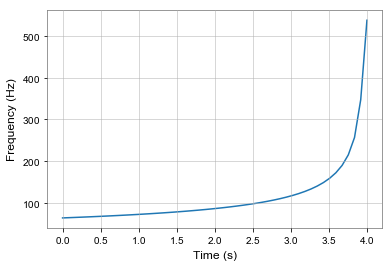

1.5653156650795115


In [135]:
# Frequency analytic
#----------------------------------------------------------------

def gwfreq(iM,iT,iT0, iCutoff):
    const = (948.5)*np.power((1./iM),5./8.)
    output = const*np.power(np.maximum((iT0-iT),3e-2), iCutoff) # we can max it out above 500 Hz-ish
    return output

times = np.linspace(0., 4., 50)
#freq = gwfreq(20, times, 4, -3.5/8)
freq = gwfreq(28.7945987, times, 4, -3.5/8)

plt.clf()
plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
#plt.savefig('model_frequency.png')
plt.show()
f = max(freq)/(2*math.pi)
print(10**-21*45/(f*3.354*10**-22))

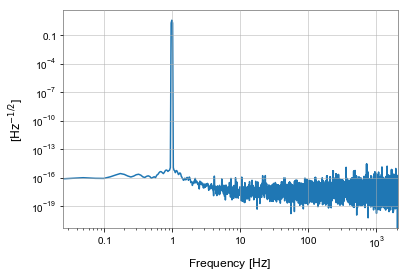

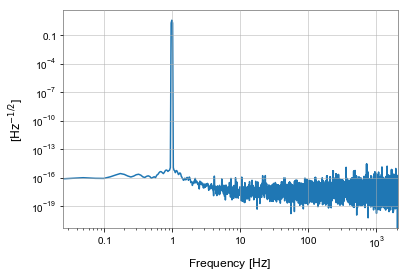

In [171]:
def osc(t, Mc, t0, C, phi, A, Cutoff):
    return C* np.multiply(np.multiply(np.power(gwfreq(Mc, t, t0, Cutoff)*Mc, 10./3.) , np.cos(gwfreq(Mc, t, t0, Cutoff) * (t - t0) + phi)), np.minimum(np.exp(A*(t0-t)), 1.))

def osc_sin(t, Mc, t0, C, phi, A, Cutoff):
    return np.cos(2*math.pi*(t-t0))

# Draw the function defined
times = np.arange(-10, 30 , 0.000244140625)
freq = osc_sin(times, 30, 0.18, 1, 0.0, 100, -3.5/8)
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
#plt.plot(times, freq)
#plt.xlabel('Time (s) since '+str(tevent))
#plt.ylabel('strain')
#plt.savefig('model_function.png')
freq_series = TimeSeries(freq, t0 = strain.t0, dt = strain.dt, name = 'Strain')
asd4 = freq_series.asd()
asd4.plot()
#plt.show()

#print(max(asd4))

In [ ]:
times = np.linspace(-0.1, 0.3, 1000)
freq = osc(times, 28.7945987, 0.17494666, -7.4573*10^-36, -1.89393127, 100, -3.5/8)

freq_TS = 

strain_data = osc()

In [232]:
def osc_dif(params, x, data, eps):
    iM=params["Mc"]
    iT0=params["t0"]
    norm=params["C"]
    phi=params["phi"]
    A=params["A"]
    val=osc(x, iM, iT0, norm, phi, 70)
    return (val-data)/eps

def white_osc_dif(params, x, data, eps):
    iM=params["Mc"]
    iT0=params["t0"]
    norm=params["C"]
    phi=params["phi"]
    #A=params["A"]
    Cutoff=-3/8
    val=white_osc(x, iM, iT0, norm, phi, Cutoff)
    return (val-data)/eps

def white_osc2_dif(params, x, data, eps):
    iM=params["Mc"]
    iT0=params["t0"]
    norm=params["C"]
    phi=params["phi"]
    #A=params["A"]
    #Cutoff=-3/8
    val=white_osc2(x, iM, iT0, norm, phi)
    return (val-data)/eps

def white_osc_fixed_dif(params, x, data, eps):
    Cutoff=params["Cutoff"]
    val=white_osc_fixed(x, Cutoff)
    return (val-data)/eps

def flat_dif(params, x, data, eps):
    iM=params["Mc"]
    iT0=params["t0"]
    norm=params["C"]
    phi=params["phi"]
    val=flat(x, iM, iT0, norm, phi)
    return (val-data)/eps

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 1228
    # variables        = 5
    chi-square         = 14662617.5
    reduced chi-square = 11989.0577
    Akaike info crit   = 11538.0584
    Bayesian info crit = 11563.6241
##  Warning: uncertainties could not be estimated:
    Mc:   at initial value
    t0:   at initial value
    A:    at initial value
    A:    at boundary
[[Variables]]
    Mc:   20.0000000 (init = 20)
    t0:   0.18000000 (init = 0.18)
    C:   -2.5304e-10 (init = 1)
    phi:  1.0852e-09 (init = 0)
    A:          -inf (init = -inf)


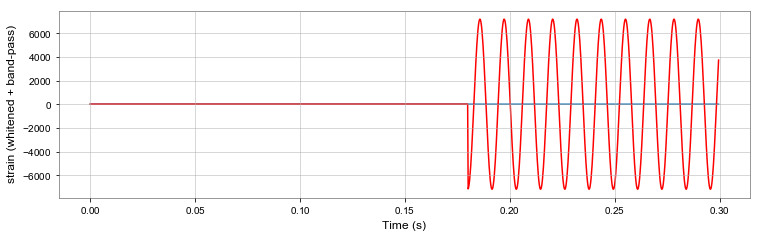

In [16]:
# Fit
#----------------------------------------------------------------

sample_times = white_data_bp2.times.value
sample_data = white_data_bp2.value
indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(20)     # Mass guess
p['t0'].set(0.18)  # By construction we put the merger in the center
p['C'].set(1)      # normalization guess
p['phi'].set(0)    # Phase guess
unc = np.full(len(white_data_bp_zoom),20)
out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
#plt.savefig('strain_fit_L1.png')
plt.show()


Text(0,0.5,'$\\chi^2$/n')

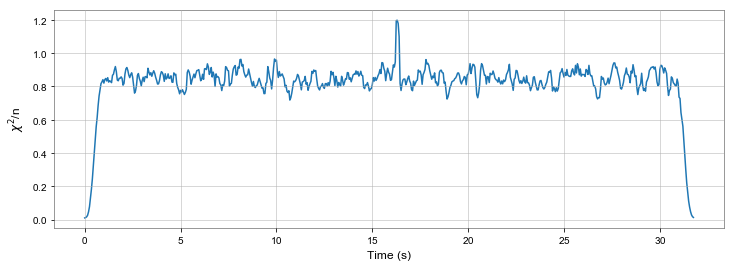

In [217]:
sample_times = white_data_bp.times.value
sample_data = white_data_bp.value

def flat(t, Mc, t0, C, phi):
    return np.zeros(len(t))

chisqrs = []
redchisqrs = []

for time in np.arange(0, sample_times[-1] - sample_times[0]-0.2, 0.05):
    indxt = np.where((sample_times >= (sample_times[0] + time)) & (sample_times < (sample_times[0] + time + 0.2)))
    x = sample_times[indxt]
    x = x-x[0]
    white_data_bp_zoom = sample_data[indxt]

    model = lmfit.Model(flat)
    p = model.make_params()
    p['Mc'].set(20)     # Mass guess
    p['t0'].set(0.18)  # By construction we put the merger in the center
    p['C'].set(1)      # normalization guess
    p['phi'].set(0)    # Phase guess
    unc = np.full(len(white_data_bp_zoom),1)
    out = minimize(flat_dif, params=p, args=(x, white_data_bp_zoom, unc))
    #print(out.chisqr)
    redchisqrs.append(out.redchi)
    chisqrs.append(out.chisqr)
plt.figure(figsize=(12, 4))
plt.plot(np.arange(0, sample_times[-1] - sample_times[0]-0.2, 0.05), redchisqrs)

plt.xlabel('Time (s)')
plt.ylabel(r'$\chi^2$/n')
#plt.savefig('chi2_time_H1_flat.png')


Text(0,0.5,'$\\chi^2$/n')

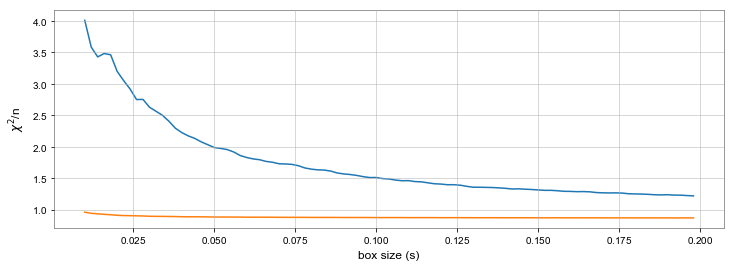

In [219]:
sample_times = white_data_bp.times.value
sample_data = white_data_bp.value


from scipy.stats import chi2

chisqrs = {}
redchisqrs = {}
maxchi=[]
maxredchi=[]
avgchi=[]
avgredchi=[]

stdchi = []
stdredchi = []

maxP = []
avgP = []

boxes = np.arange(0.01, 0.2, 0.002)

for box in boxes:

    chisqrs[box] = []
    redchisqrs[box] = []

    for time in np.arange(tevent-2.5, tevent+2.5, 0.01):
        indxt = np.where((sample_times >= (time)) & (sample_times < (time + box)))
        x = sample_times[indxt]
        x = x-x[0]
        white_data_bp_zoom = sample_data[indxt]

        model = lmfit.Model(flat)
        p = model.make_params()
        p['Mc'].set(20)     # Mass guess
        p['t0'].set(0.18)  # By construction we put the merger in the center
        p['C'].set(1)      # normalization guess
        p['phi'].set(0)    # Phase guess
        unc = np.full(len(white_data_bp_zoom),1)
        out = minimize(flat_dif, params=p, args=(x, white_data_bp_zoom, unc))
        #print(out.chisqr)
        redchisqrs[box].append(out.redchi)
        chisqrs[box].append(out.chisqr)
    maxredchi.append(max(redchisqrs[box]))
    maxchi.append(max(chisqrs[box]))
    avgredchi.append(sum(redchisqrs[box])/len(chisqrs[box]))
    avgchi.append(sum(chisqrs[box])/len(chisqrs[box]))
    maxP.append(chi2.cdf(max(chisqrs[box]) , int(max(chisqrs[box])/max(redchisqrs[box]))))
    avgP.append(chi2.cdf((sum(chisqrs[box])/len(chisqrs[box])) , int(max(chisqrs[box])/max(redchisqrs[box]))))
    stdchi.append(stdev(chisqrs[box]))
    stdredchi.append(stdev(redchisqrs[box]))
    
    
plt.figure(figsize=(12, 4))
plt.plot(boxes, maxredchi)
plt.plot(boxes, avgredchi)

plt.xlabel('box size (s)')
plt.ylabel(r'$\chi^2$/n')
    #plt.savefig('chi2_time_H1_flat.png')
  

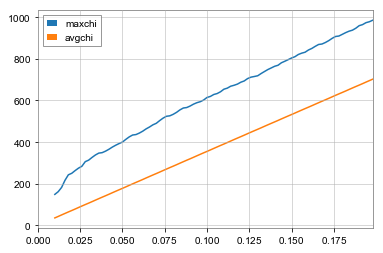

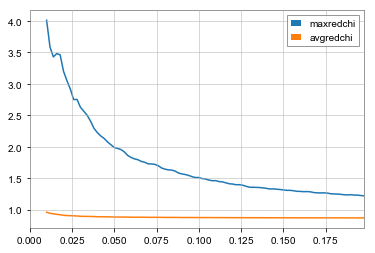

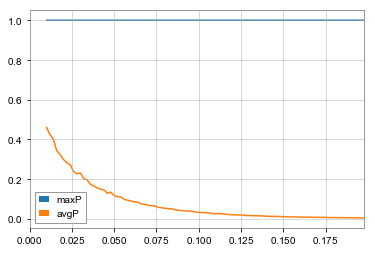

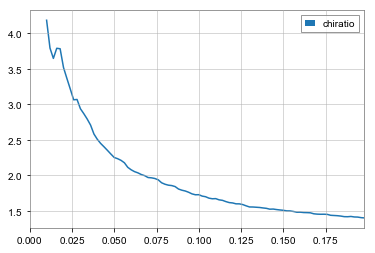

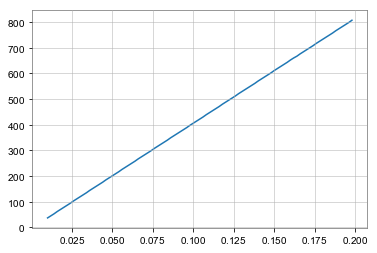

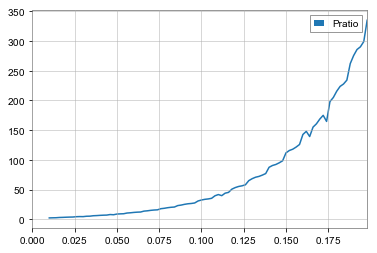

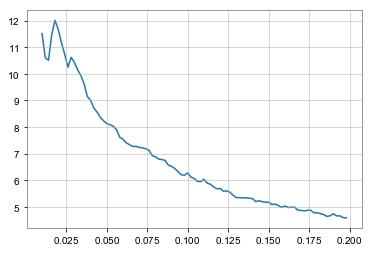

In [220]:
from statistics import stdev

fig1, ax1 = plt.subplots() #MIT STP vs Shimadzu
fig2, ax2 = plt.subplots() #MIT -35 vs Shimadzu
fig3, ax3 = plt.subplots() #MIT -43 vs Shimadzu
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
fig6, ax6 = plt.subplots()
fig7, ax7 = plt.subplots()

chiratio = []
ndof = []
Pratio = []

chidiff = []
redchidiff = []

for i in range(len(maxchi)):
    chiratio.append(maxchi[i]/avgchi[i])
    ndof.append(maxchi[i]/maxredchi[i])
    Pratio.append(maxP[i]/avgP[i])
    chidiff.append(maxchi[i] - avgchi[i])
    redchidiff.append(maxredchi[i] - avgredchi[i])
 
stdratio = []

for i in range(len(chidiff)):
    stdratio.append(chidiff[i]/stdchi[i])
    
#plt.figure(figsize=(12, 4))
#ax2.figure(figsize=(12, 4))
#ax3.figure(figsize=(12, 4))

ax1.plot(boxes, maxchi, label = 'maxchi')
ax1.plot(boxes, avgchi, label = 'avgchi')

ax2.plot(boxes, maxredchi, label = 'maxredchi')
ax2.plot(boxes, avgredchi, label = 'avgredchi')

ax3.plot(boxes, maxP, label = 'maxP')
ax3.plot(boxes, avgP, label = 'avgP')

ax4.plot(boxes, chiratio, label = 'chiratio')
#ax4.plot(boxes, chiratio)

ax5.plot(boxes, ndof)

ax6.plot(boxes, Pratio, label = 'Pratio')

ax7.plot(boxes, stdratio)
#ax7.plot(boxes, chidiff)

for ax in [ax1, ax2, ax3, ax4, ax6]:
    ax.set_xlim(0, max(boxes))
    ax.legend()
    #ax.set_ylim(0,

#print(stdev(Pratio))
#print(int(max(chisqrs[box])/max(redchisqrs[box])))

#plt.xlabel('box size (s)')
#plt.ylabel(r'$\chi^2$/n')

Text(0,0.5,'$\\chi^2$/n')

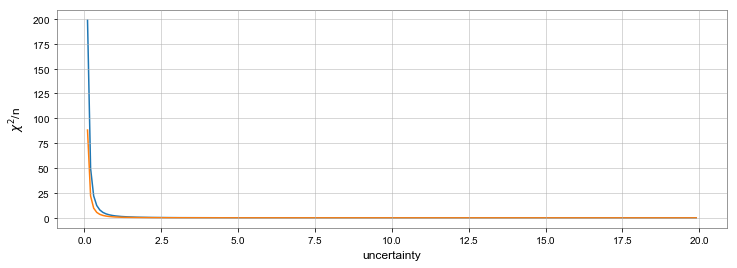

In [222]:
sample_times = white_data_bp.times.value
sample_data = white_data_bp.value


from scipy.stats import chi2

chisqrs = {}
redchisqrs = {}
maxchi=[]
maxredchi=[]
avgchi=[]
avgredchi=[]

stdchi = []
stdredchi = []

maxP = []
avgP = []

errs = np.arange(0.1, 20, 0.1)

for err in errs:

    chisqrs[err] = []
    redchisqrs[err] = []

    for time in np.arange(tevent-2.5, tevent+2.5, 0.01):
        indxt = np.where((sample_times >= (time)) & (sample_times < (time + 0.05)))
        x = sample_times[indxt]
        x = x-x[0]
        white_data_bp_zoom = sample_data[indxt]

        model = lmfit.Model(flat)
        p = model.make_params()
        p['Mc'].set(20)     # Mass guess
        p['t0'].set(0.18)  # By construction we put the merger in the center
        p['C'].set(1)      # normalization guess
        p['phi'].set(0)    # Phase guess
        unc = np.full(len(white_data_bp_zoom), err)
        out = minimize(flat_dif, params=p, args=(x, white_data_bp_zoom, unc))
        #print(out.chisqr)
        redchisqrs[err].append(out.redchi)
        chisqrs[err].append(out.chisqr)
    maxredchi.append(max(redchisqrs[err]))
    maxchi.append(max(chisqrs[err]))
    avgredchi.append(sum(redchisqrs[err])/len(chisqrs[err]))
    avgchi.append(sum(chisqrs[err])/len(chisqrs[err]))
    maxP.append(chi2.cdf(max(chisqrs[err]) , int(max(chisqrs[err])/max(redchisqrs[err]))))
    avgP.append(chi2.cdf((sum(chisqrs[err])/len(chisqrs[err])) , int(max(chisqrs[err])/max(redchisqrs[err]))))
    stdchi.append(stdev(chisqrs[err]))
    stdredchi.append(stdev(redchisqrs[err]))
    
    
plt.figure(figsize=(12, 4))
plt.plot(errs, maxredchi)
plt.plot(errs, avgredchi)

plt.xlabel('uncertainty')
plt.ylabel(r'$\chi^2$/n')
    #plt.savefig('chi2_time_H1_flat.png')
  

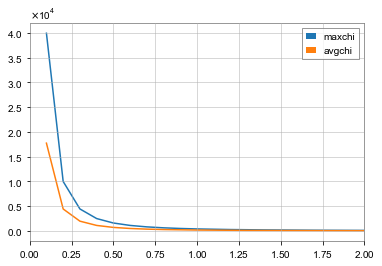

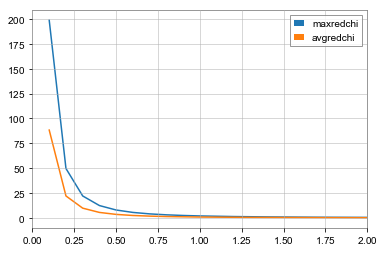

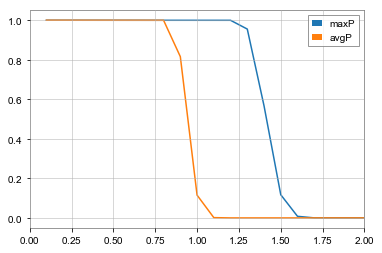

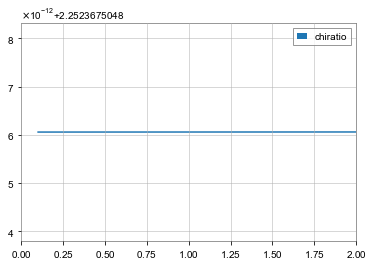

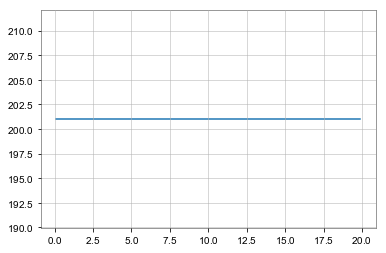

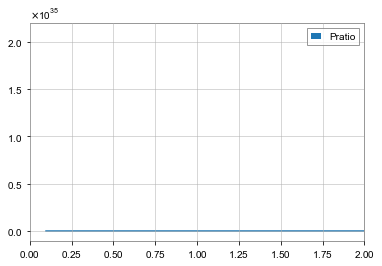

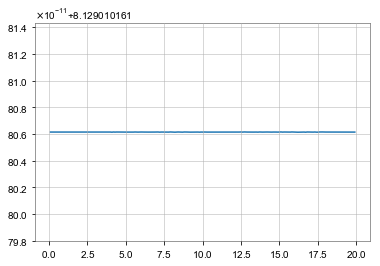

In [229]:
from statistics import stdev

fig1, ax1 = plt.subplots() #MIT STP vs Shimadzu
fig2, ax2 = plt.subplots() #MIT -35 vs Shimadzu
fig3, ax3 = plt.subplots() #MIT -43 vs Shimadzu
fig4, ax4 = plt.subplots()
fig5, ax5 = plt.subplots()
fig6, ax6 = plt.subplots()
fig7, ax7 = plt.subplots()

chiratio = []
ndof = []
Pratio = []

chidiff = []
redchidiff = []

for i in range(len(maxchi)):
    chiratio.append(maxchi[i]/avgchi[i])
    ndof.append(maxchi[i]/maxredchi[i])
    Pratio.append(maxP[i]/avgP[i])
    chidiff.append(maxchi[i] - avgchi[i])
    redchidiff.append(maxredchi[i] - avgredchi[i])
 
stdratio = []

for i in range(len(chidiff)):
    stdratio.append(chidiff[i]/stdchi[i])
    
#plt.figure(figsize=(12, 4))
#ax2.figure(figsize=(12, 4))
#ax3.figure(figsize=(12, 4))

ax1.plot(errs, maxchi, label = 'maxchi')
ax1.plot(errs, avgchi, label = 'avgchi')

ax2.plot(errs, maxredchi, label = 'maxredchi')
ax2.plot(errs, avgredchi, label = 'avgredchi')

ax3.plot(errs, maxP, label = 'maxP')
ax3.plot(errs, avgP, label = 'avgP')

ax4.plot(errs, chiratio, label = 'chiratio')
#ax4.plot(boxes, chiratio)

ax5.plot(errs, ndof)

ax6.plot(errs, Pratio, label = 'Pratio')

ax7.plot(errs, stdratio)
#ax7.plot(boxes, chidiff)

for ax in [ax1, ax2, ax3, ax4, ax6]:
    ax.set_xlim(0, 2)
    ax.legend()
    #ax.set_ylim(0,

#print(stdev(Pratio))
#print(int(max(chisqrs[box])/max(redchisqrs[box])))

#plt.xlabel('box size (s)')
#plt.ylabel(r'$\chi^2$/n')

240.68420030343975
1.1974338323554217
201.0


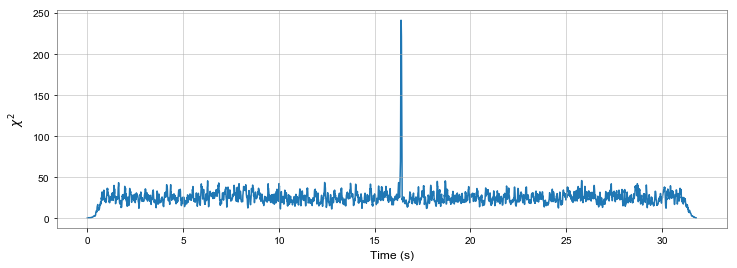

In [126]:
plt.figure(figsize=(12, 4))
plt.plot(np.arange(0, sample_times[-1] - sample_times[0]-0.2, 0.01), chisqrs)

plt.xlabel('Time (s)')
plt.ylabel(r'$\chi^2$')
#plt.savefig('chi2_time_L1_flat_2.png')

print(max(chisqrs))
print(max(redchisqrs))
print(max(chisqrs)/max(redchisqrs))

1024


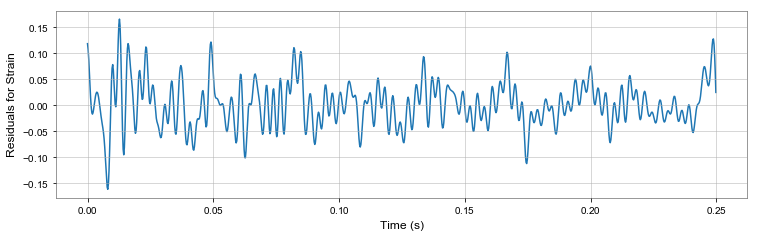

In [172]:
residuals = white_data_bp_zoom - model.eval(params=out.params,t=x)
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
print(len(residuals))
plt.xlabel('Time (s)')
plt.ylabel('Residuals for Strain')
plt.plot(x, residuals)
plt.savefig('strain_residuals_L1.png')

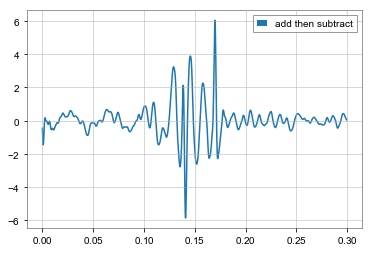

In [231]:
def white_osc(t, Mc, t0, C, phi, Cutoff): #appends model to the end of noise. whitens and filters, then cuts off the noise
    timevals = strain.times.value
    datas = strain.value

    indxt = np.where((timevals >= (tevent+0.5)) & (timevals < (tevent+15)))
    x1s = timevals[indxt]
    x1s=x1s-x1s[0]
    a=np.empty(len(t)); a.fill(x1s[1]+x1s[-1])

    x2s = np.take(x1s, np.arange(0,200))
    
    xs = np.array(list(x1s) + list(x2s + x1s[-1] + x1s[1]))

    #a=np.empty(len(t)); a.fill(xs[1]+xs[-1])
    xs_short = np.take(xs, np.arange(0, len(t)))

    doublex = np.array(list(xs) + list(xs_short+a))

    data = list(datas[indxt]) + [0] * 200 #adds some zeros to avoid a weird boundary spike from whitening

    #print((data))
    #print(len(x))

    event = osc(t, Mc, t0, C, phi, 100, Cutoff)
    total_data = np.array(list(data)+ list(event))

    TS = TimeSeries(data, times = xs)

    total_TS = TimeSeries(total_data, t0 = strain.t0, dt = strain.dt, name = 'Strain')
    #print(total_TS)
    white_total_TS = total_TS.whiten()
    white_TS = TS.whiten()


    bandpass_low = 15
    bandpass_high = 400

    white_total_TS_bp = white_total_TS.bandpass(bandpass_low, bandpass_high)

    indices = np.arange(len(xs), len(doublex))

    model_array = np.take(white_total_TS_bp.value , indices) #just take the portion of the array with the model

    return model_array

def white_osc2(t, Mc, t0, C, phi): # add the model on top of the noise, whiten and filter, then subtract the whitened and filtered noise. len(t) must be even
    timevals = strain2.times.value
    datas = strain2.value

    indxt = np.where((timevals >= (tevent+0.5)) & (timevals < (tevent+15)))
    xs = timevals[indxt]
    xs=xs-xs[0]

    data = datas[indxt]

    #print((data))
    #print(len(x))

    event = osc(t, Mc, t0, C, phi, 100, -3.5/8)
    
    
    a = [0] * int((len(data) - len(event))/2)
    total_data = np.array(a +  list(event) + a) + np.array(data) #place the model in the middle of the noise.

    TS = TimeSeries(data, t0 = strain2.t0, dt = strain2.dt, name = 'Strain')

    total_TS = TimeSeries(total_data, t0 = strain2.t0, dt = strain2.dt, name = 'Strain')
    #print(total_TS)
    white_total_TS = total_TS.whiten()
    white_TS = TS.whiten()


    bandpass_low = 15
    bandpass_high = 400

    white_total_TS_bp = white_total_TS.bandpass(bandpass_low, bandpass_high)
    white_TS_bp = white_TS.bandpass(bandpass_low, bandpass_high)
    
    diff = white_total_TS_bp.value - white_TS_bp.value #subtract noise from noise + model

    indices = np.arange(int((len(data) - len(event))/2), int((len(data) + len(event))/2))

    model_array = np.take(diff , indices) #just take the portion of the array with the model

    return model_array

def white_osc_fixed(t, Cutoff): # add the model on top of the noise, whiten and filter, then subtract the whitened and filtered noise. len(t) must be even
    timevals = strain.times.value
    datas = strain.value

    indxt = np.where((timevals >= (tevent+0.5)) & (timevals < (tevent+15)))
    xs = timevals[indxt]
    xs=xs-xs[0]

    data = datas[indxt]

    #print((data))
    #print(len(x))

    event = osc(t, 28.7945987, 0.17494666, -7.4573*10**-36, -1.89393127, 100, Cutoff)
    
    
    a = [0] * int((len(data) - len(event))/2)
    total_data = np.array(a +  list(event) + a) + np.array(data) #place the model in the middle of the noise.

    TS = TimeSeries(data, t0 = strain2.t0, dt = strain2.dt, name = 'Strain')

    total_TS = TimeSeries(total_data, t0 = strain2.t0, dt = strain2.dt, name = 'Strain')
    #print(total_TS)
    white_total_TS = total_TS.whiten()
    white_TS = TS.whiten()


    bandpass_low = 15
    bandpass_high = 400

    white_total_TS_bp = white_total_TS.bandpass(bandpass_low, bandpass_high)
    white_TS_bp = white_TS.bandpass(bandpass_low, bandpass_high)
    
    diff = white_total_TS_bp.value - white_TS_bp.value #subtract noise from noise + model

    indices = np.arange(int((len(data) - len(event))/2), int((len(data) + len(event))/2))

    model_array = np.take(diff , indices) #just take the portion of the array with the model

    return model_array

#white_TS = 

#white_total_TS.plot()

timevals = strain2.times.value
datas = strain2.value

indxt = np.where((timevals >= (tevent+0.5)) & (timevals < (tevent+15)))
xs = timevals[indxt]
xs=xs-xs[0]

indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]

m2_array = white_osc2(x, 30, 0.17, 5*10**-34, 0)

m1_array = white_osc(x, 30, 0.17, 5*10**-34, 0, -3/8)

m3_array = osc(x, 30, 0.17, 8*10**-14, 0, 70, -3/8)

plt.plot(x, m2_array, label = 'add then subtract')
#plt.plot(x, m1_array, label = 'append model at end')
plt.legend()
#plt.plot(x, m3_array)
#plt.plot(doublex, white_total_TS.value)
#plt.xlim(6.7, 7.1)
#plt.ylim(-20,20)

#print((white_total_TS))

59392
[29082 29083 29084 ... 30307 30308 30309]
59392
59392


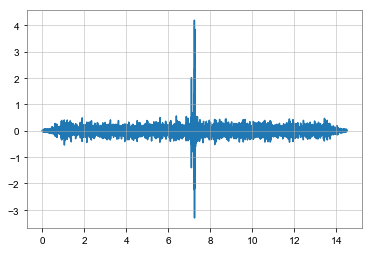

In [247]:

indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]

timevals = strain.times.value
datas = strain.value
indxt = np.where((timevals >= (tevent+0.5)) & (timevals < (tevent+15)))
xs = timevals[indxt]
xs=xs-xs[0]

data = datas[indxt]

#print((data))
#print(len(x))

event = osc(x, 30, 0.17, 5*10**-34, 0, 100)


a = [0] * int((len(data) - len(event))/2)
total_data = np.array(a +  list(event) + a) + np.array(data)

TS = TimeSeries(data, t0 = strain.t0, dt = strain.dt, name = 'Strain')

total_TS = TimeSeries(total_data, t0 = strain.t0, dt = strain.dt, name = 'Strain')
#print(total_TS)
white_total_TS = total_TS.whiten()
white_TS = TS.whiten()


bandpass_low = 15
bandpass_high = 400

white_total_TS_bp = white_total_TS.bandpass(bandpass_low, bandpass_high)
white_TS_bp = white_TS.bandpass(bandpass_low, bandpass_high)

diff = white_total_TS_bp.value - white_TS_bp.value

indices = np.arange(int((len(data) - len(event))/2), int(((len(data) + len(event))/2)))

model_array = np.take(diff , indices)

print(len(diff))
print(indices)
print(len(total_data))
print(len(xs))
      
plt.plot(xs, diff)

In [155]:
timevals = strain.times.value
datas = strain.value

indxt = np.where((timevals >= (tevent+0.5)) & (timevals < (tevent+15)))
x1s = timevals[indxt]
x1s=x1s-x1s[0]
a=np.empty(len(t)); a.fill(x1s[1]+x1s[-1])

x2s = np.take(x1s, np.arange(0,200))
    
xs = np.array(list(x1s) + list(x2s + x1s[-1] + x1s[1]))

t=xs

a=np.empty(len(t)); a.fill(xs[1]+xs[-1])
xs_short = np.take(xs, np.arange(0, len(t)))

doublex = np.array(list(xs) + list(xs_short+a))
    

print(len(xs)- len(x1s))

200


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 1228
    # variables        = 4
    chi-square         = 269.221529
    reduced chi-square = 0.21995223
    Akaike info crit   = -1855.62206
    Bayesian info crit = -1835.16949
##  Warning: uncertainties could not be estimated:
    Mc:   at initial value
    t0:   at initial value
    C:    at initial value
    C:    at boundary
[[Variables]]
    Mc:   28.0000000 (init = 28)
    t0:   0.18000000 (init = 0.18)
    C:    0.00000000 (init = 5e-34)
    phi:  0.00000000 (init = 0)


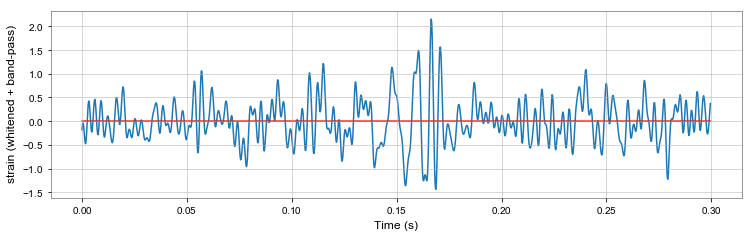

In [251]:
# Fit
#----------------------------------------------------------------

sample_times = white_data_bp2.times.value
sample_data = white_data_bp2.value
indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(white_osc2)
p = model.make_params()
p['Mc'].set(28)     # Mass guess
p['t0'].set(0.18)  # By construction we put the merger in the center
p['C'].set(5*10**-34)      # normalization guess
p['phi'].set(0)    # Phase guess
#p['Cutoff'].set(-5/8, max = -3/8, min = -3.00000001/8)
#p['A'].set(70)#, min = 69.9, max = 70)     #decay rate guess
unc = np.full(len(white_data_bp_zoom),1)
out = minimize(white_osc2_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
#plt.savefig('strain_fit_H1_2.png')
plt.show()


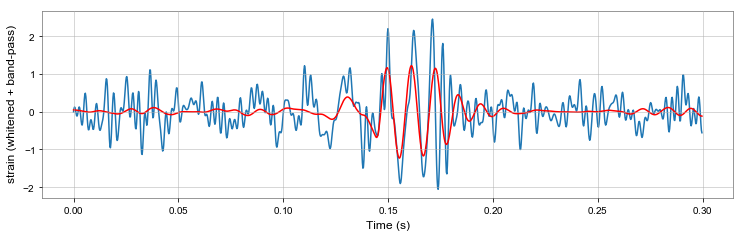

In [111]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
plt.savefig('strain_fit_whitened_H1_2.png')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 1228
    # variables        = 1
    chi-square         = 303.614387
    reduced chi-square = 0.24744449
    Akaike info crit   = -1713.98715
    Bayesian info crit = -1708.87401
[[Variables]]
    Cutoff: -0.43741615 +/- 0.00133373 (0.30%) (init = -0.4375)


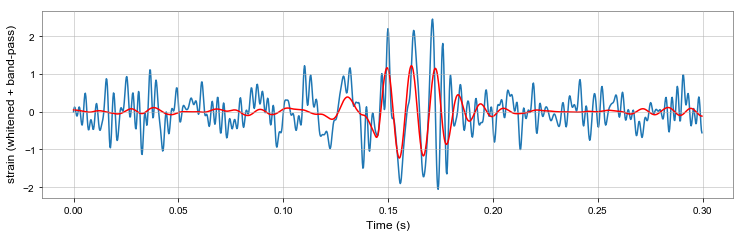

In [240]:
# Fit with everything fixed except the cutoff
#----------------------------------------------------------------

sample_times = white_data_bp.times.value
sample_data = white_data_bp.value
indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(white_osc_fixed)
p = model.make_params()
#p['Mc'].set(28)     # Mass guess
#p['t0'].set(0.18)  # By construction we put the merger in the center
#p['C'].set(5*10**-34)      # normalization guess
#p['phi'].set(0)    # Phase guess
p['Cutoff'].set(-3.5/8)
#p['A'].set(70)#, min = 69.9, max = 70)     #decay rate guess
unc = np.full(len(white_data_bp_zoom),1)
out = minimize(white_osc_fixed_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
#plt.savefig('strain_fit_H1_2.png')
plt.show()
